# CLASS-HDS Demo

Reproducing figures from https://arxiv.org/pdf/2211.13653

In [1]:
from numbers import Number
import matplotlib.pyplot as plt
import numpy as np
from classy import Class

In [2]:
# Helper functions to evoke class and get quantities of interest
h = 0.6756
def get_model(case):
    c = Class()
    if isinstance(case, Number):
        phi_i = case
        pars = {
            # Cosmological parameters
            "H0": 100*h,
            "omega_b": 0.022,
            "omega_cdm": 0.12,
            "A_s": 2.215e-9,
            "n_s": 0.962,
            "tau_reio": 0.0544,
            "N_ur": 3.044,
            "N_ncdm": 0,
            "YHe": 0.246,
            # Dark Energy parameters
            "Omega_Lambda": 0.0,
            "Omega_fld": 0.0,
            "Omega_scf": -1.0, # NOTE: setting negative values of Omega_scf will trigger the shooting
            "scf_parameters": f"100,{phi_i}", # NOTE: scf_parameters is organized as follows: the first index represents V0 (it shoots so the value does not matter), the second represents the field initial value
            "scf_tuning_index": 0,
            # CLASS settings
            "gauge": "synchronous",
            "lensing": "yes",
            "non_linear": "hmcode",
            "output": "mPk,tCl,pCl,lCl",
            "l_max_scalars": 3000,
            "P_k_max_h/Mpc": 10,
            "z_max_pk": 3
        }
    elif case == "LCDM":
        pars = {
            # Cosmological parameters
            "H0": 100*h,
            "omega_b": 0.022,
            "omega_cdm": 0.12,
            "A_s": 2.215e-9,
            "n_s": 0.962,
            "tau_reio": 0.0544,
            "N_ur": 3.044,
            "N_ncdm": 0,
            "YHe": 0.246,
            # CLASS settings
            "gauge": "synchronous",
            "lensing": "yes",
            "non_linear": "hmcode",
            "output": "mPk,tCl,pCl,lCl",
            "l_max_scalars": 3000,
            "P_k_max_h/Mpc": 10,
            "z_max_pk": 3
        }
    c.set(pars)
    c.compute()
    return c

def get_densities(c):
    # Returns rho(z) for different species
    bg = c.get_background()
    z = bg["z"]
    rho_cdm = bg["(.)rho_cdm"]
    rho_b = bg["(.)rho_b"]
    rho_nu_massless = bg["(.)rho_ur"]
    rho_phot = bg["(.)rho_g"]
    if "(.)rho_scf" in bg.keys(): rho_de = bg["(.)rho_scf"]
    else: rho_de = bg["(.)rho_lambda"]
    rho_tot = bg["(.)rho_tot"]
    return z, rho_cdm, rho_b, rho_phot+rho_nu_massless, rho_de, rho_tot

def get_phi(c):
    bg = c.get_background()
    return bg["phi_scf"]

def get_hubble(c):
    # Returns H(z)
    bg = c.get_background()
    return bg["H [1/Mpc]"]

def get_fractions(c):
    # Returns rho(z)/rho_tot(z) for different species
    z, rho_cdm, rho_b, rho_r, rho_de, rho_tot = get_densities(c)
    return z, rho_cdm/rho_tot, rho_b/rho_tot, rho_r/rho_tot, rho_de/rho_tot

def check_omegas(c):
    # Checks if the shooting is working
    z, f_cdm, f_b, f_r, f_scf = get_fractions(c)
    omega_m = (0.022 + 0.12)/(0.6756)**2
    omega_scf = 1 - omega_m - f_r[-1]
    actual_omega_m = f_cdm[-1] + f_b[-1]
    actual_omega_scf = f_scf[-1]
    print(f"Omega_m: expected {omega_m}, got {actual_omega_m}, relative error = {(actual_omega_m-omega_m)/omega_m}")
    print(f"Omega_de: expected {omega_scf}, got {actual_omega_scf}, relative error = {(actual_omega_scf-omega_scf)/omega_scf}")

def get_cls_and_pks(c):
    # Returns C_l^TT and P(k)
    k = np.logspace(-3, -1, 200) # In h/Mpc
    z = np.zeros(1)
    pk = c.get_pk_array(k*h, z, len(k), 1, False) # NOTE: the get_pk_array method uses units of 1/Mpc
    class_cls = c.lensed_cl()
    ells = class_cls['ell']
    cls = ells*(ells+1)*class_cls['tt']/(2*np.pi)
    return k, pk*h**3, ells, cls

In [3]:
cases = [8, 10, 15, 20, "LCDM"]
models = {}
for case in cases:
    models[case] = get_model(case)
    print(f"Finished computing {case}")

Finished computing 8
Finished computing 10
Finished computing 15
Finished computing 20
Finished computing LCDM


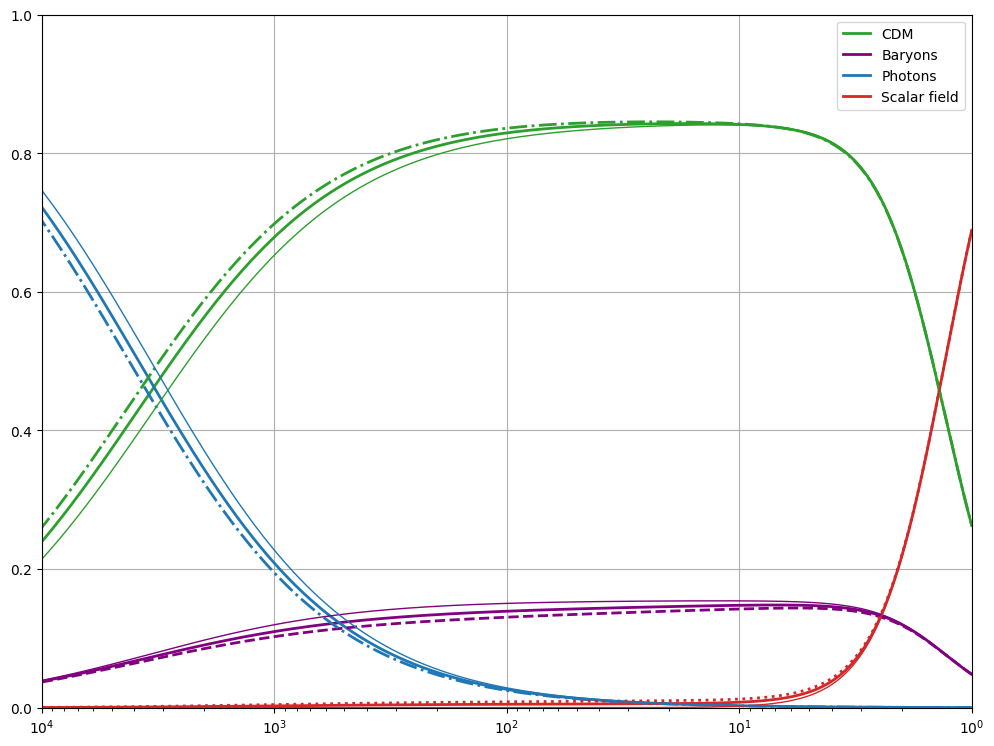

In [4]:
# Figure 1 - left panel
z, f_cdm_8, f_b_8, f_r_8, f_de_8             = get_fractions(models[8])
z, f_cdm_10, f_b_10, f_r_10, f_de_10         = get_fractions(models[10])
z, f_cdm_lcdm, f_b_lcdm, f_r_lcdm, f_de_lcdm = get_fractions(models["LCDM"])

plt.figure(figsize=(12, 9))
lw = 2
plt.semilogx(1+z, f_cdm_10, color="tab:green", label="CDM", lw=lw)
plt.semilogx(1+z, f_b_10, color="purple", label="Baryons", lw=lw)
plt.semilogx(1+z, f_r_10, color="tab:blue", label="Photons", lw=lw)
plt.semilogx(1+z, f_de_10, color="tab:red", label="Scalar field", lw=lw)
plt.semilogx(1+z, f_cdm_8, color="tab:green", ls="-.", lw=lw)
plt.semilogx(1+z, f_b_8, color="purple", ls="--", lw=lw)
plt.semilogx(1+z, f_r_8, color="tab:blue", ls="-.", lw=lw)
plt.semilogx(1+z, f_de_8, color="tab:red", ls=":", lw=lw)
plt.semilogx(1+z, f_cdm_lcdm, color="tab:green", lw=1)
plt.semilogx(1+z, f_b_lcdm, color="purple", lw=1)
plt.semilogx(1+z, f_r_lcdm, color="tab:blue", lw=1)
plt.semilogx(1+z, f_de_lcdm, color="tab:red", lw=1)
plt.xlim([1e4, 1])
plt.ylim([0, 1])
plt.legend()
plt.grid()

Text(0, 0.5, '$\\Delta H/H$ (%)')

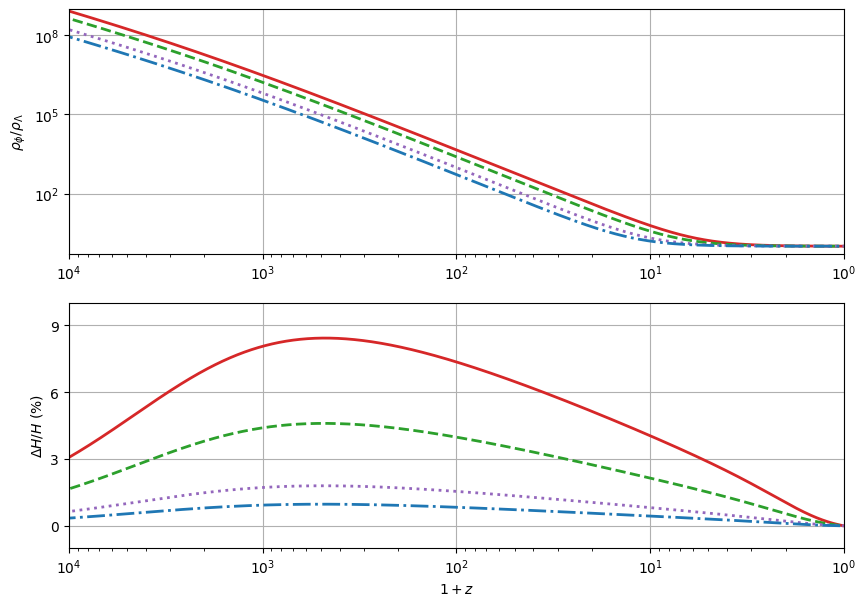

In [5]:
# Figure 1 - right panels
z, rho_cdm_8, rho_b_8, rho_r_8, rho_de_8, rho_tot_8 = get_densities(models[8])
z, rho_cdm_10, rho_b_10, rho_r_10, rho_de_10, rho_tot_10 = get_densities(models[10])
z, rho_cdm_15, rho_b_15, rho_r_15, rho_de_15, rho_tot_15 = get_densities(models[15])
z, rho_cdm_20, rho_b_20, rho_r_20, rho_de_20, rho_tot_20 = get_densities(models[20])
z, rho_cdm_lcdm, rho_b_lcdm, rho_r_lcdm, rho_de_lcdm, rho_tot_lcdm = get_densities(models["LCDM"])

fig, axs = plt.subplots(2, 1, figsize=(10, 7))
axs[0].loglog(1 + z, rho_de_8/rho_de_lcdm, color="tab:red", ls="-", lw=2)
axs[0].loglog(1 + z, rho_de_10/rho_de_lcdm, color="tab:green", ls="--", lw=2)
axs[0].loglog(1 + z, rho_de_15/rho_de_lcdm, color="tab:purple", ls=":", lw=2)
axs[0].loglog(1 + z, rho_de_20/rho_de_lcdm, color="tab:blue", ls="-.", lw=2)

axs[1].semilogx(1 + z, 100*(get_hubble(models[8])/get_hubble(models["LCDM"]) - 1), color="tab:red", ls="-", lw=2)
axs[1].semilogx(1 + z, 100*(get_hubble(models[10])/get_hubble(models["LCDM"]) - 1), color="tab:green", ls="--", lw=2)
axs[1].semilogx(1 + z, 100*(get_hubble(models[15])/get_hubble(models["LCDM"]) - 1), color="tab:purple", ls=":", lw=2)
axs[1].semilogx(1 + z, 100*(get_hubble(models[20])/get_hubble(models["LCDM"]) - 1), color="tab:blue", ls="-.", lw=2)
for ax in axs:
    ax.set_xlim([1e4, 1])
    ax.grid()
axs[0].set_ylim([5e-1, 1e9])
axs[1].set_ylim([-1, 10])
axs[0].set_yticks([1e2, 1e5, 1e8])
axs[1].set_yticks([0, 3, 6, 9])
axs[0].set_ylabel(r"$\rho_\phi/\rho_\Lambda$")
axs[1].set_xlabel(r"$1 + z$")
axs[1].set_ylabel(r"$\Delta H/H$ (%)")

In [6]:
# Checking the omegas
for model in models.values():
    check_omegas(model)

Omega_m: expected 0.31110648394988505, got 0.311106430590905, relative error = -1.715135582849116e-07
Omega_de: expected 0.6888018801512871, got 0.6888019335102672, relative error = 7.746636828509239e-08
Omega_m: expected 0.31110648394988505, got 0.311106483392659, relative error = -1.7911103491338378e-09
Omega_de: expected 0.6888018801577562, got 0.6888018807149823, relative error = 8.089786905890238e-10
Omega_m: expected 0.31110648394988505, got 0.3111064839524842, relative error = 8.35451286630413e-12
Omega_de: expected 0.6888018801578262, got 0.6888018801552269, relative error = -3.7735874714175365e-12
Omega_m: expected 0.31110648394988505, got 0.31110648395014967, relative error = 8.505822654664855e-13
Omega_de: expected 0.688801880157826, got 0.6888018801575614, relative error = -3.840961448995384e-13
Omega_m: expected 0.31110648394988505, got 0.31110648394988505, relative error = 0.0
Omega_de: expected 0.688801880157826, got 0.688801880157826, relative error = 0.0


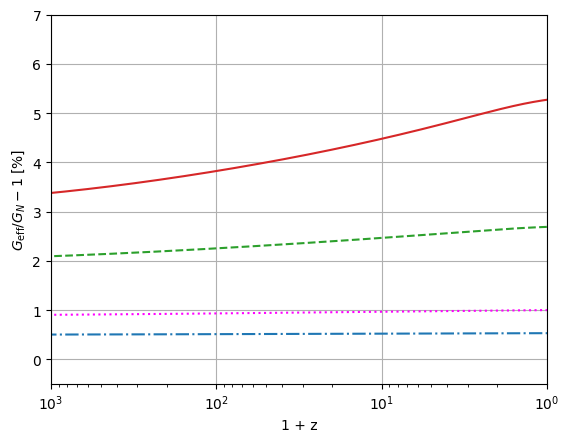

In [7]:
# Checking the phi evolution
styles = [
    ["tab:red", "-"],
    ["tab:green", "--"],
    ["magenta", ":"],
    ["tab:blue", "-."],
]
for (key, model), style in zip(models.items(), styles):
    if key == "LCDM": continue
    color, ls = style
    phi = get_phi(model)
    Geff = 2/phi**2
    plt.semilogx(1+z, Geff*100, color=color, ls=ls)
plt.xlim([1e3, 1])
plt.ylim([-0.5, 7])
plt.xlabel("1 + z")
plt.ylabel(r"$G_\mathrm{eff}/G_N - 1$ [%]")
plt.grid()

/tmp/ipykernel_35020/3661200038.py:17: RuntimeWarning: invalid value encountered in divide
  axs[1, 0].semilogx(ell, cl/cl_lcdm - 1, color=color, ls=ls, lw=lw)


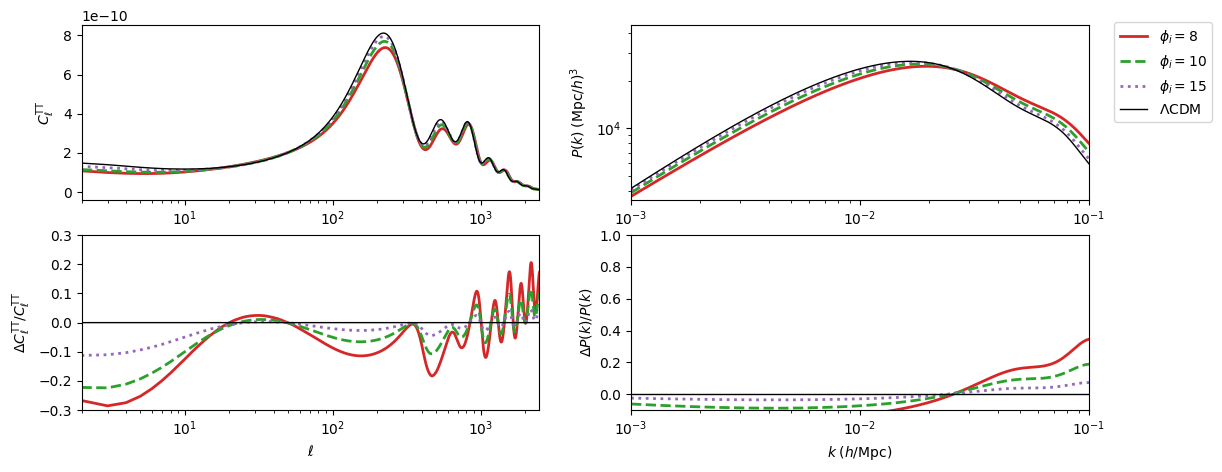

In [8]:
# Extracting P(k) and temperature C_l
fig, axs = plt.subplots(2, 2, figsize=(13, 5))
styles = [
    ["tab:red", "-", 2],
    ["tab:green", "--", 2],
    ["tab:purple", ":", 2],
    [None, None, None],
    ["black", "-", 1],
]
k, pk_lcdm, ell, cl_lcdm = get_cls_and_pks(models["LCDM"])
for (key, model), style in zip(models.items(), styles):
    if key == 20: continue
    color, ls, lw = style
    k, pk, ell, cl = get_cls_and_pks(model)
    axs[0, 0].semilogx(ell, cl, color=color, ls=ls, lw=lw, label=rf"$\phi_i = {key}$" if key != "LCDM" else r"$\Lambda$CDM")
    axs[0, 1].loglog(k, pk, color=color, ls=ls, lw=lw)
    axs[1, 0].semilogx(ell, cl/cl_lcdm - 1, color=color, ls=ls, lw=lw)
    axs[1, 1].semilogx(k, pk/pk_lcdm - 1, color=color, ls=ls, lw=lw)

axs[0, 0].set_xlim([2, 2500])
axs[1, 0].set_xlim([2, 2500])
axs[1, 0].set_ylim([-0.3, 0.3])
axs[0, 1].set_xlim([1e-3, 1e-1])
axs[1, 1].set_xlim([1e-3, 1e-1])
axs[0, 1].set_ylim([3.5e3, 4.5e4])
axs[1, 1].set_ylim([-0.1, 1])
axs[0, 0].set_xlabel(r"$\ell$")
axs[0, 0].set_ylabel(r"$C_\ell^\mathrm{TT}$")
axs[1, 0].set_xlabel(r"$\ell$")
axs[1, 0].set_ylabel(r"$\Delta C_\ell^\mathrm{TT} / C_\ell^\mathrm{TT}$")
axs[0, 1].set_xlabel(r"$k\; (h/\mathrm{Mpc})$")
axs[0, 1].set_ylabel(r"$P(k)\; (\mathrm{Mpc}/h)^3$")
axs[1, 1].set_xlabel(r"$k\; (h/\mathrm{Mpc})$")
axs[1, 1].set_ylabel(r"$\Delta P(k) / P(k)$")
fig.legend(bbox_to_anchor=(1, 0.9))
plt.savefig("/home/joao/HDS_CLASS_WITH_PERTURBATIONS.pdf")

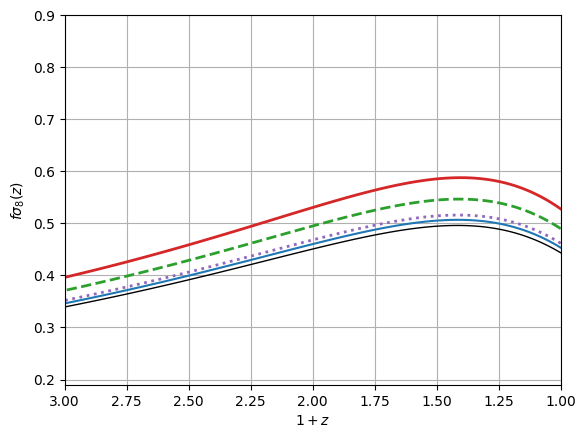

In [9]:
zz = np.linspace(0, 2, 100)
for (key, model), style in zip(models.items(), styles):
    color, ls, lw = style
    fs8 = np.array([model.scale_independent_f_sigma8(z) for z in zz])
    plt.plot((1+zz), fs8, color=color, ls=ls, lw=lw)
plt.xlim([3, 1])
plt.ylim([0.19, 0.9])
plt.xlabel(r"$1 + z$")
plt.ylabel(r"$f\sigma_8(z)$")
plt.grid()